In [1]:
import openai
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import re
import time
import pickle
import copy
import json
import requests
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
filepath='./'
plotpath='./'
assert os.path.exists(filepath)

In [2]:
col_order=[
 'gpt-4','text-bison-001','deepseek-v2.5','gpt-4o','gpt-3.5','text-davinci-003','text-davinci-002','claude-instant',   
'qwen-72b', 'qwen-32b', 'openchat-13b','wizardlm-13b','vicuna-13b','llama2-13b','oasst-12b',
'qwen-7b','vicuna-7b','llama2-7b','chatglm2-6b',
]
len(col_order)

19

In [5]:
df=pd.read_excel(os.path.join(filepath,'domain_results_v2.xlsx'))
df['Domain'].fillna(method='ffill', inplace=True)

print(df.shape)
df.head()

(18, 28)


,Domain,Type,Metric,Human,gpt-4o,gpt-4,gpt-3.5,deepseek-v2.5,bard,text-bison-001,...,llama2-13b,oasst-12b,qwen-7b,vicuna-7b,llama2-7b,chatglm2-6b,Max_score,Min_score,Reverse,Show
0,Size,NaN,NaN,NaN,200.000,1800.000,175.000,236.000,137.000,340.000,...,13.000,12.000,7.000,7.000,7.000,6.000,NaN,NaN,NaN,NaN
1,Psychology,Theoretical,NaN,0.528,0.750,0.800,0.758,0.758,0.737,0.520,...,0.813,0.645,0.742,0.770,0.588,0.533,NaN,NaN,NaN,NaN
2,Psychology,Practical,NaN,0.632,0.690,0.634,0.639,0.769,0.671,0.764,...,0.625,0.667,0.773,0.736,0.690,0.681,NaN,NaN,NaN,NaN
3,Psychology,Overall,NaN,0.591,0.714,0.700,0.686,0.764,0.698,0.666,...,0.700,0.658,0.761,0.750,0.649,0.622,NaN,NaN,NaN,NaN
4,Cognitive and Behavioral Science,Theoretical,NaN,0.569,0.703,0.684,0.525,0.701,0.580,0.457,...,0.456,0.333,0.608,0.374,0.375,0.399,NaN,NaN,NaN,NaN


# modelsize vs rationality

In [6]:
df['name']=df['Domain']+'\n'+df['Type']
df1=df[['name']+col_order]
# df1=df1.set_index('name')
model_size=df1.iloc[0,:]
model_size=model_size.iloc[1:]

df1=df1.iloc[1:,:].set_index('name')
df1
# model_size

,gpt-4,text-bison-001,deepseek-v2.5,gpt-4o,gpt-3.5,text-davinci-003,text-davinci-002,claude-instant,qwen-72b,qwen-32b,openchat-13b,wizardlm-13b,vicuna-13b,llama2-13b,oasst-12b,qwen-7b,vicuna-7b,llama2-7b,chatglm2-6b
name,,,,,,,,,,,,,,,,,,,
Psychology\nTheoretical,0.800,0.520,0.758,0.750,0.758,0.850,0.780,0.730,0.925,0.830,0.704,0.758,0.754,0.813,0.645,0.742,0.770,0.588,0.533
Psychology\nPractical,0.634,0.764,0.769,0.690,0.639,0.917,0.750,0.588,0.787,0.763,0.805,0.792,0.611,0.625,0.667,0.773,0.736,0.690,0.681
Psychology\nOverall,0.700,0.666,0.764,0.714,0.686,0.890,0.762,0.645,0.842,0.790,0.765,0.778,0.668,0.700,0.658,0.761,0.750,0.649,0.622
Cognitive and Behavioral Science\nTheoretical,0.684,0.457,0.701,0.703,0.525,0.447,0.462,0.478,0.715,0.689,0.421,0.429,0.392,0.456,0.333,0.608,0.374,0.375,0.399
Cognitive and Behavioral Science\nPractical,0.717,0.521,0.598,0.660,0.474,0.507,0.640,0.740,0.757,0.714,0.557,0.660,0.724,0.695,0.543,0.814,0.579,0.471,0.576
Cognitive and Behavioral Science\nOverall,0.688,0.461,0.668,0.685,0.501,0.445,0.503,0.547,0.726,0.694,0.446,0.486,0.483,0.513,0.392,0.664,0.419,0.382,0.458
Decision Making\nPractical,0.704,0.473,0.525,0.686,0.426,0.391,0.528,0.455,0.758,0.648,0.385,0.392,0.462,0.487,0.452,0.633,0.375,0.356,0.495
Decision Making\nOverall,0.704,0.473,0.525,0.686,0.426,0.391,0.528,0.455,0.758,0.648,0.385,0.392,0.462,0.487,0.452,0.633,0.375,0.356,0.495
Economics\nTheoretical,0.920,0.960,0.960,0.960,0.900,0.670,0.860,0.930,0.930,0.930,0.920,0.920,0.830,0.830,0.570,0.960,0.570,0.790,0.670


## overall rationality

In [7]:
# overall results
average_row = df1.mean().round(3)
# df1.loc['Overall']=average_row
# df1
average_row

gpt-4               0.708
text-bison-001      0.585
deepseek-v2.5       0.666
gpt-4o              0.720
gpt-3.5             0.575
text-davinci-003    0.567
text-davinci-002    0.587
claude-instant      0.599
qwen-72b            0.760
qwen-32b            0.712
openchat-13b        0.591
wizardlm-13b        0.587
vicuna-13b          0.557
llama2-13b          0.556
oasst-12b           0.462
qwen-7b             0.686
vicuna-7b           0.503
llama2-7b           0.475
chatglm2-6b         0.502
dtype: float64

In [8]:
assert average_row.index.tolist()==model_size.index.tolist()
models=average_row.index.tolist()
sizes=model_size.values*10**9
rationalities=average_row.values

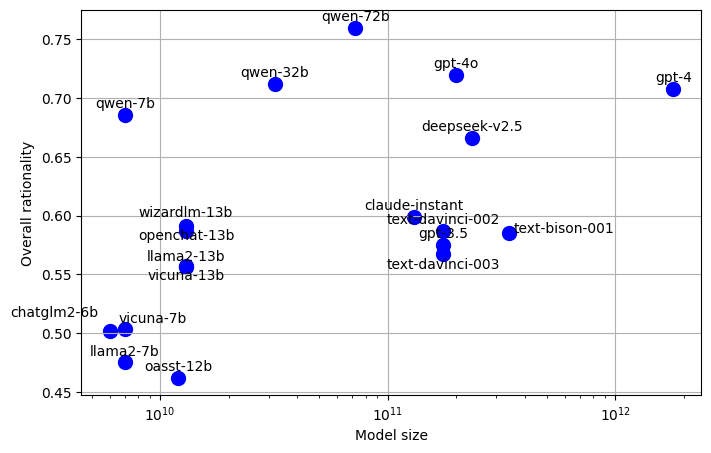

In [26]:
# 创建散点图
plt.figure(figsize=(8, 5))  # 设置图形大小
plt.scatter(sizes, rationalities, marker='o', c='b', s=100)  # 创建散点图
# plt.plot(sizes, rationalities, 'o-b')  # 创建散点图

# 计算拟合直线的系数（通过最小二乘法）
# slope, intercept = np.polyfit(sizes.tolist(), rationalities.tolist(), 1)
# fit_line = slope * sizes + intercept
# plt.plot(sizes, fit_line, color='black', linewidth=2)

# 添加模型名称标签
for i, model in enumerate(models):
    if model=='text-bison-001':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(40, 0), ha='center')
    elif model=='text-davinci-003':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -10), ha='center')
    elif model=='text-davinci-002':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    elif model=='claude-instant':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    elif model=='wizardlm-13b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    elif model=='openchat-13b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -10), ha='center')
    elif model=='vicuna-13b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -10), ha='center')
    elif model=='vicuna-7b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(20, 5), ha='center')
    elif model=='chatglm2-6b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(-40, 10), ha='center')
    else:
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# 设置坐标轴
plt.xscale('log')  # 设置横轴为对数坐标
plt.xlabel('Model size')  # 设置横轴标签
plt.ylabel('Overall rationality')  # 设置纵轴标签

# 显示图形
plt.grid(True)
# plt.title('All domains')
plt.savefig(os.path.join(plotpath, 'size.pdf'), bbox_inches='tight')
plt.show()

## (x)modelsize vs domain rationality

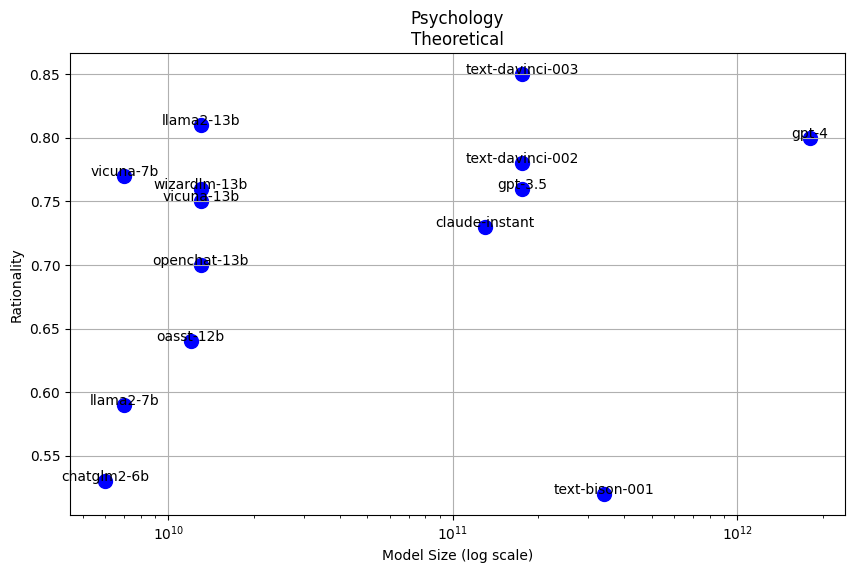

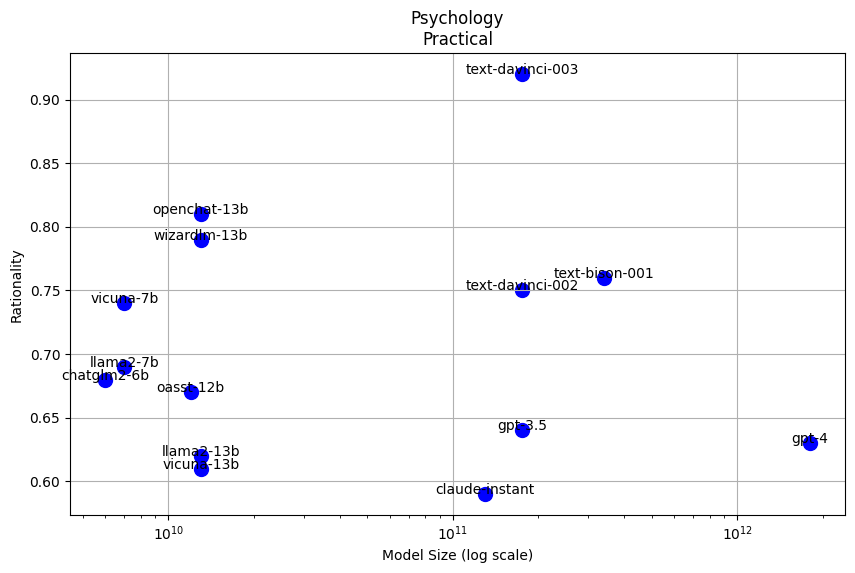

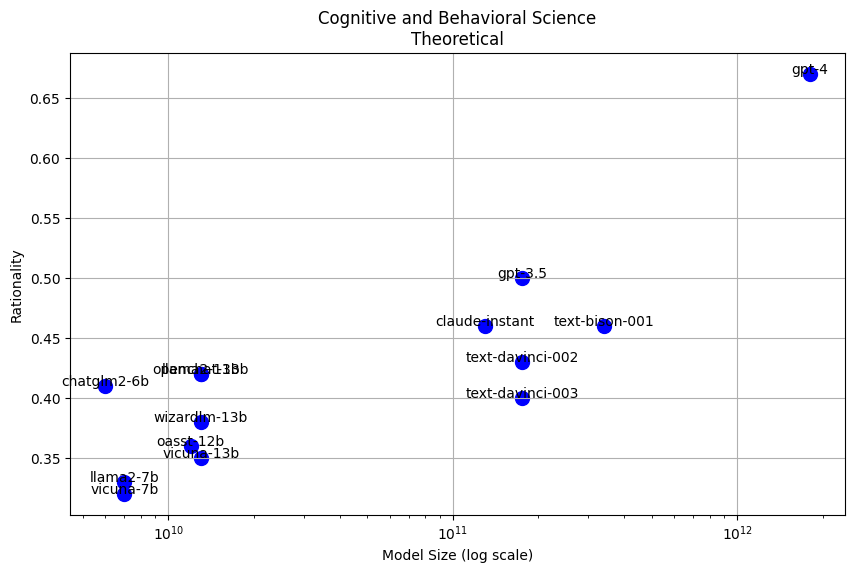

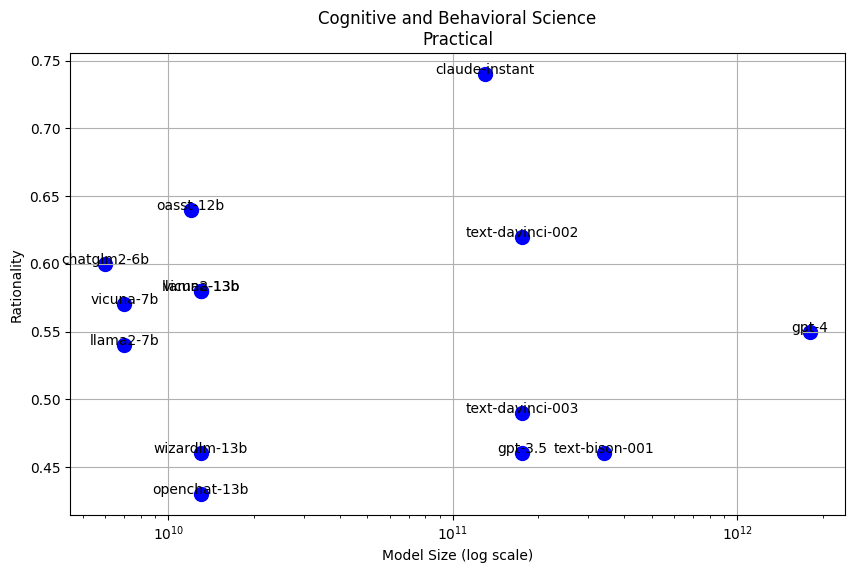

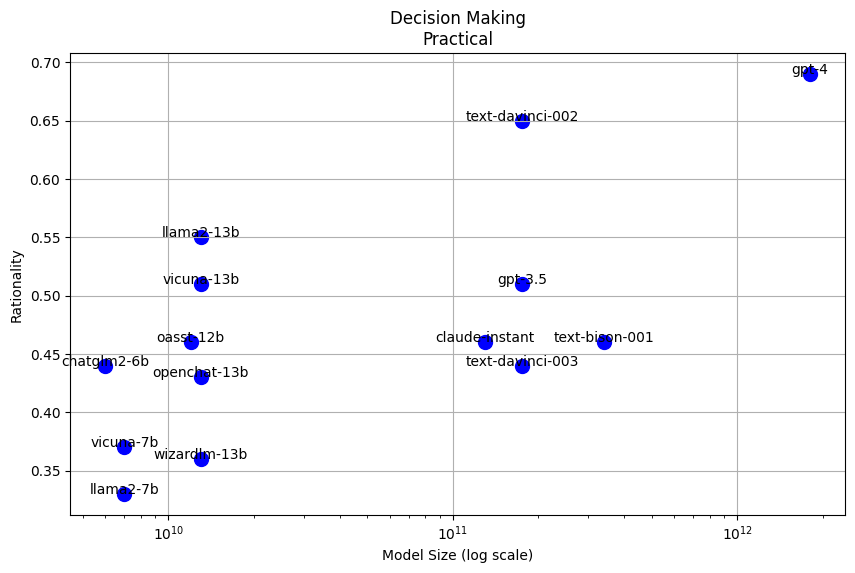

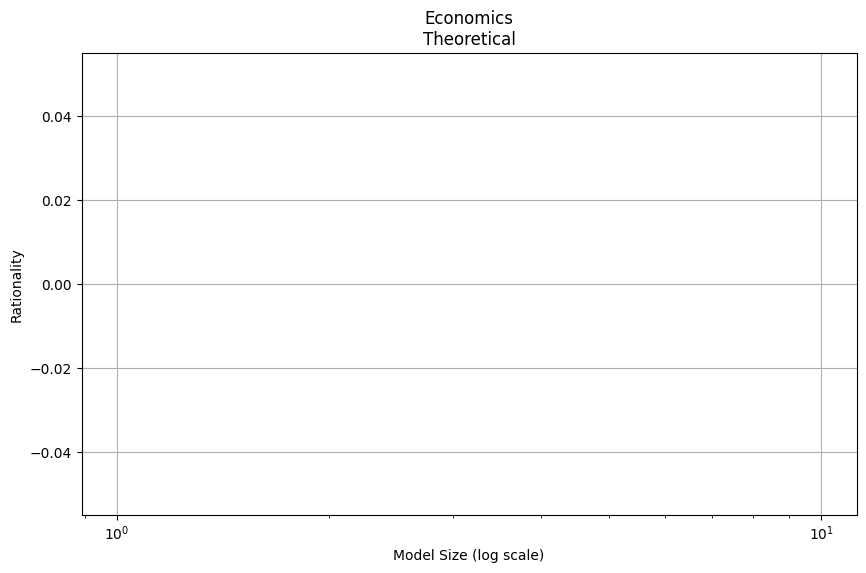

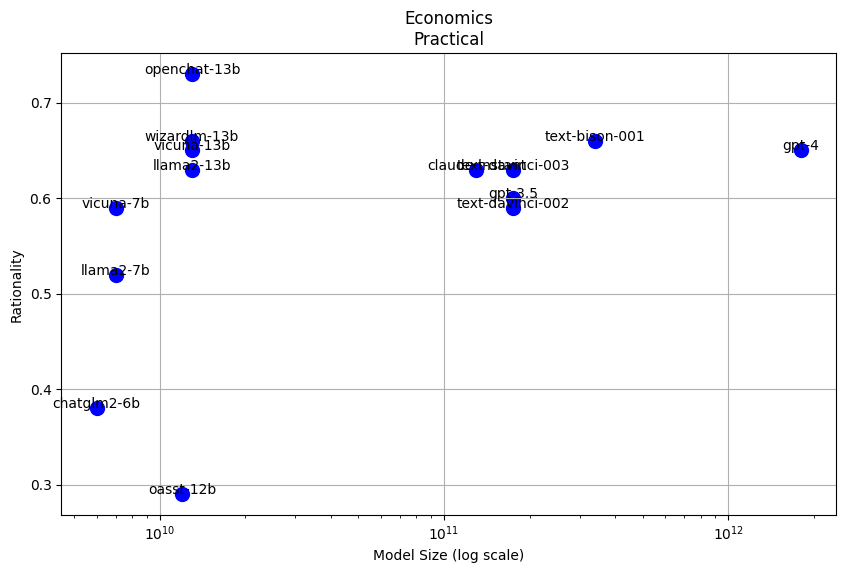

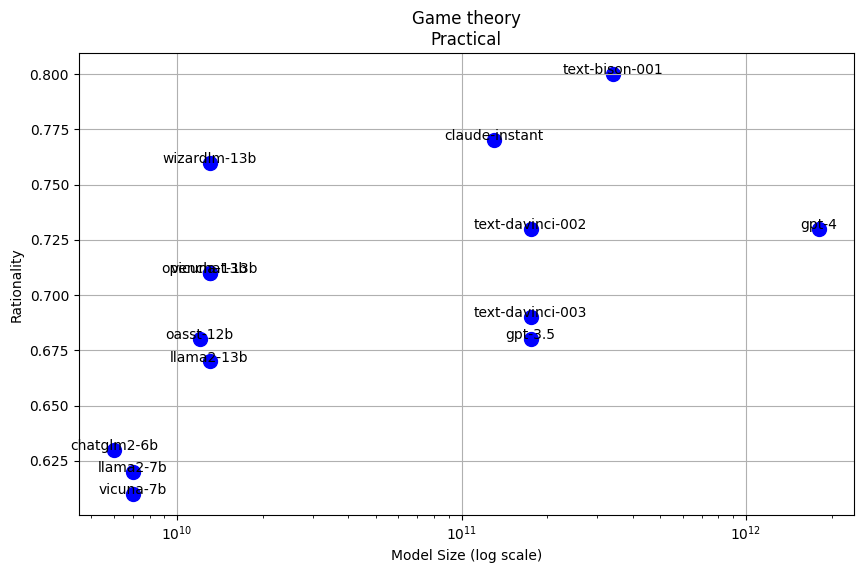

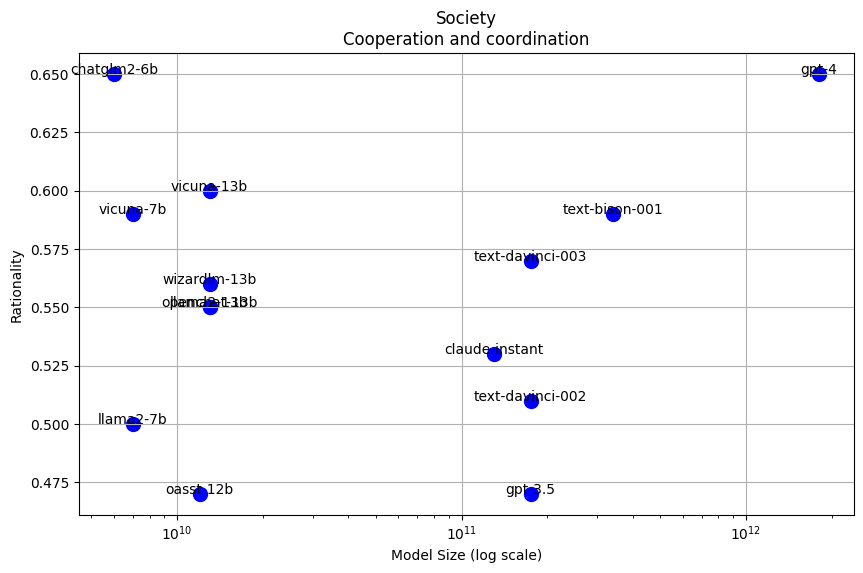

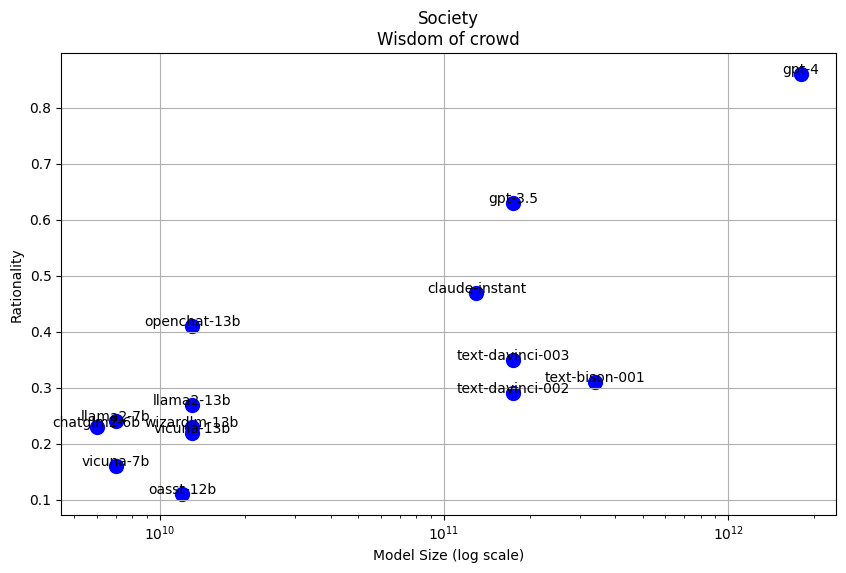

In [96]:
sizes=model_size.values*10**9

for domain in df1.index:
    average_row = df1.loc[domain,:]
    assert average_row.index.tolist()==model_size.index.tolist()
    models=average_row.index.tolist()
    rationalities=average_row.values
    
    # 创建散点图
    plt.figure(figsize=(10, 6))  # 设置图形大小
    plt.scatter(sizes, rationalities, marker='o', c='b', s=100)  # 创建散点图
#     plt.plot(sizes, rationalities, 'o-b')  # 创建折线图

    # 添加模型名称标签
    for i, model in enumerate(models):
#         if model=='text-davinci-002':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -5), ha='center')
#         elif model=='text-davinci-003':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
#         elif model=='wizardlm-13b':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
#         elif model=='vicuna-13b':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -5), ha='center')
#         else:
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 0), ha='center')

    # 设置坐标轴
    plt.xscale('log')  # 设置横轴为对数坐标
    plt.xlabel('Model Size (log scale)')  # 设置横轴标签
    plt.ylabel('Rationality')  # 设置纵轴标签

    # 显示图形
    plt.grid(True)
    plt.title(f'{domain}')
    plt.show()

# training size vs rationality

In [27]:
sel_cols=['text-bison-001','text-davinci-003','text-davinci-002','llama2-13b','llama2-7b','chatglm2-6b']


df['name']=df['Domain']+'\n'+df['Type']

df1=df[df['Type']!='Overall']

df1=df1[['name']+sel_cols]
# df1=df1.set_index('name')
model_size=df1.iloc[0,:]
model_size=model_size.iloc[1:]

df1=df1.iloc[1:,:].set_index('name')
df1
# model_size

,text-bison-001,text-davinci-003,text-davinci-002,llama2-13b,llama2-7b,chatglm2-6b
name,,,,,,
Psychology\nTheoretical,0.520,0.850,0.780,0.813,0.588,0.533
Psychology\nPractical,0.764,0.917,0.750,0.625,0.690,0.681
Cognitive and Behavioral Science\nTheoretical,0.457,0.447,0.462,0.456,0.375,0.399
Cognitive and Behavioral Science\nPractical,0.521,0.507,0.640,0.695,0.471,0.576
Decision Making\nPractical,0.473,0.391,0.528,0.487,0.356,0.495
Economics\nTheoretical,0.960,0.670,0.860,0.830,0.790,0.670
Economics\nPractical,0.582,0.590,0.616,0.563,0.416,0.485
Game theory\nPractical,0.780,0.510,0.620,0.480,0.500,0.360
Society\nCooperation and coordination,0.590,0.570,0.510,0.550,0.500,0.650


## overall rationality

In [9]:
# overall results
average_row = df1.mean().round(2)
# df1.loc['Overall']=average_row
# df1
average_row

text-bison-001      0.59
text-davinci-003    0.57
text-davinci-002    0.59
llama2-13b          0.57
llama2-7b           0.49
chatglm2-6b         0.50
dtype: float64

In [10]:
# assert average_row.index.tolist()==model_size.index.tolist()
models=average_row.index.tolist()
sizes=[3600,300,300,2000,2000,1400]
sizes=np.array(sizes,dtype=np.int64)*(10**9)
rationalities=average_row.values
print(models)
print(sizes)
print(rationalities)

['text-bison-001', 'text-davinci-003', 'text-davinci-002', 'llama2-13b', 'llama2-7b', 'chatglm2-6b']
[3600000000000  300000000000  300000000000 2000000000000 2000000000000
 1400000000000]
[0.59 0.57 0.59 0.57 0.49 0.5 ]


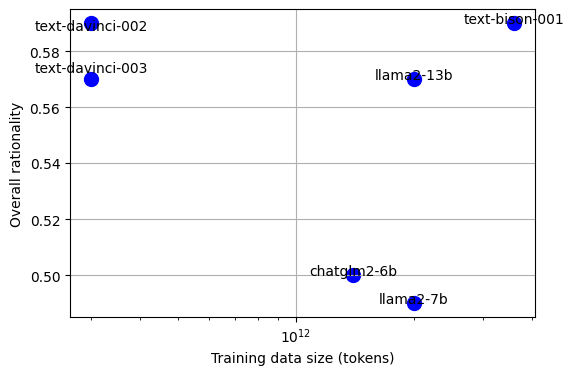

In [11]:
# 创建散点图
plt.figure(figsize=(6, 4))  # 设置图形大小
plt.scatter(sizes, rationalities, marker='o', c='b', s=100)  # 创建散点图
# plt.plot(sizes, rationalities, 'o-b')  # 创建散点图

# 添加模型名称标签
for i, model in enumerate(models):
    if model=='text-davinci-002':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -5), ha='center')
    elif model=='text-davinci-003':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    elif model=='wizardlm-13b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    elif model=='vicuna-13b':
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -5), ha='center')
    else:
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 0), ha='center')

# 设置坐标轴
plt.xscale('log')  # 设置横轴为对数坐标
plt.xlabel('Training data size (tokens)')  # 设置横轴标签
plt.ylabel('Overall rationality')  # 设置纵轴标签

# 显示图形
plt.grid(True)
# plt.title('All domains')
plt.savefig(os.path.join(plotpath, 'datasize.pdf'), bbox_inches='tight')
plt.show()

##  domain rationality

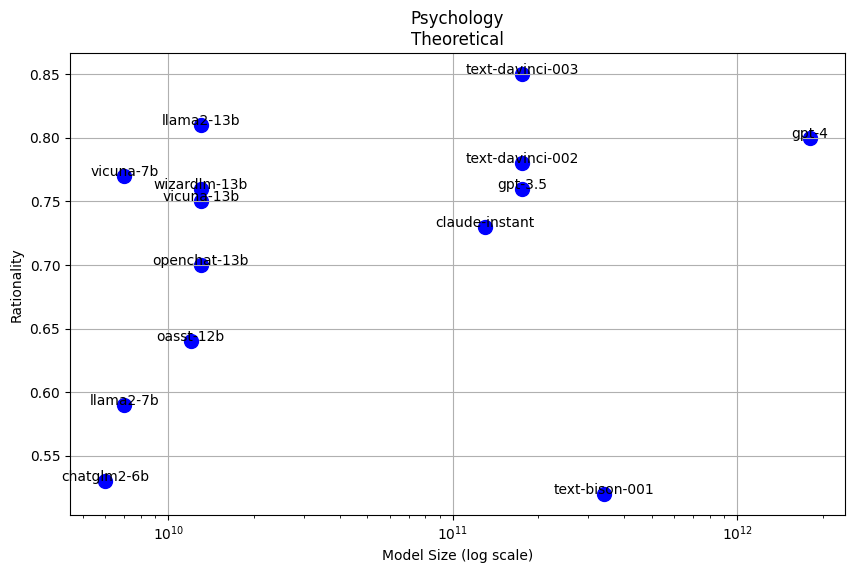

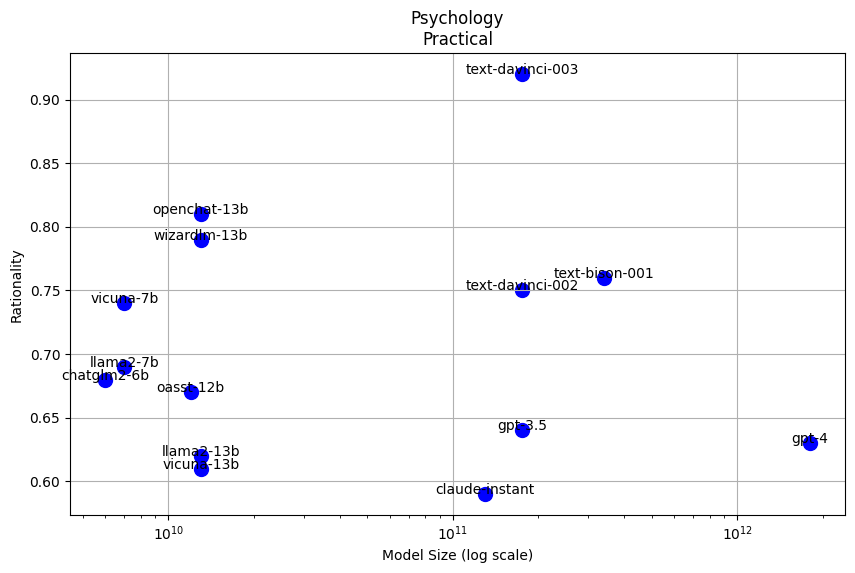

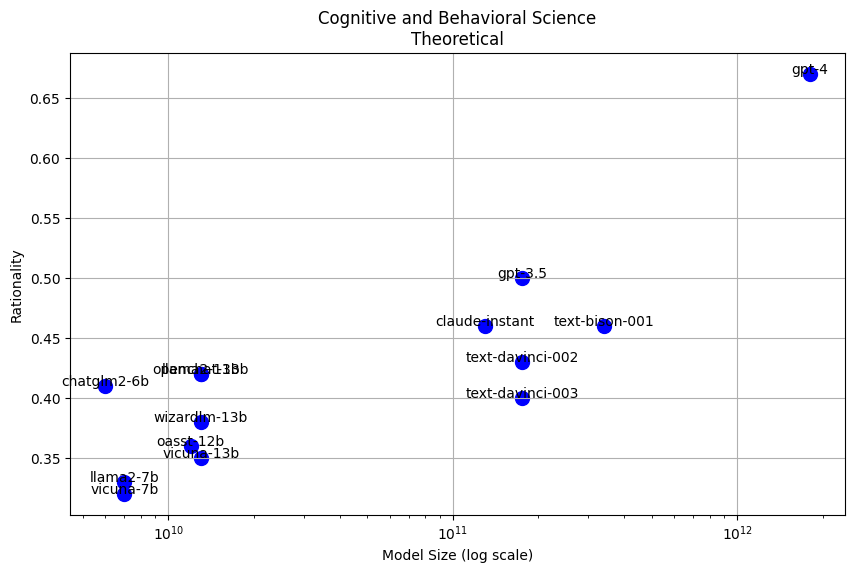

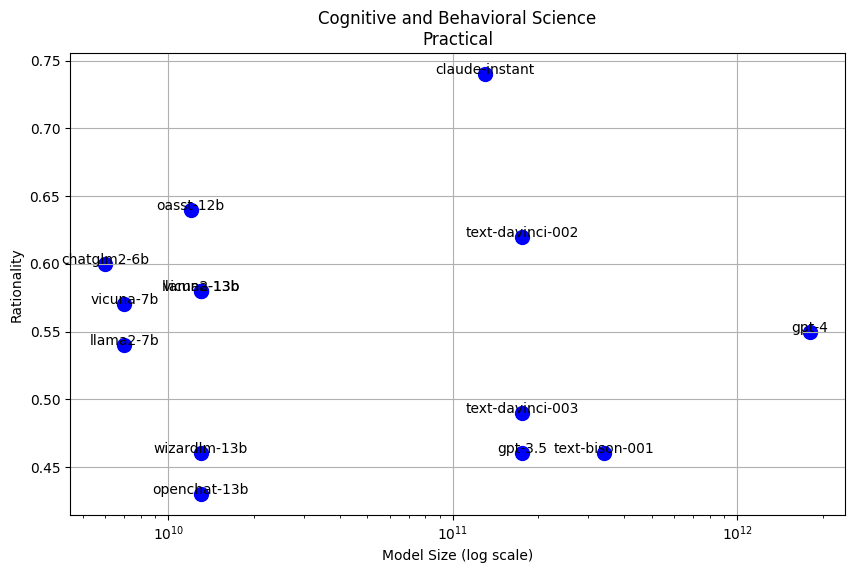

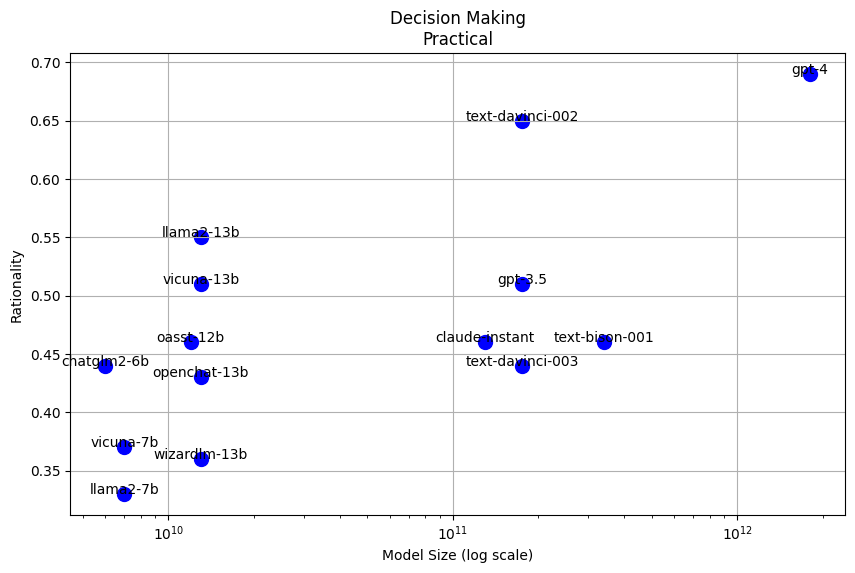

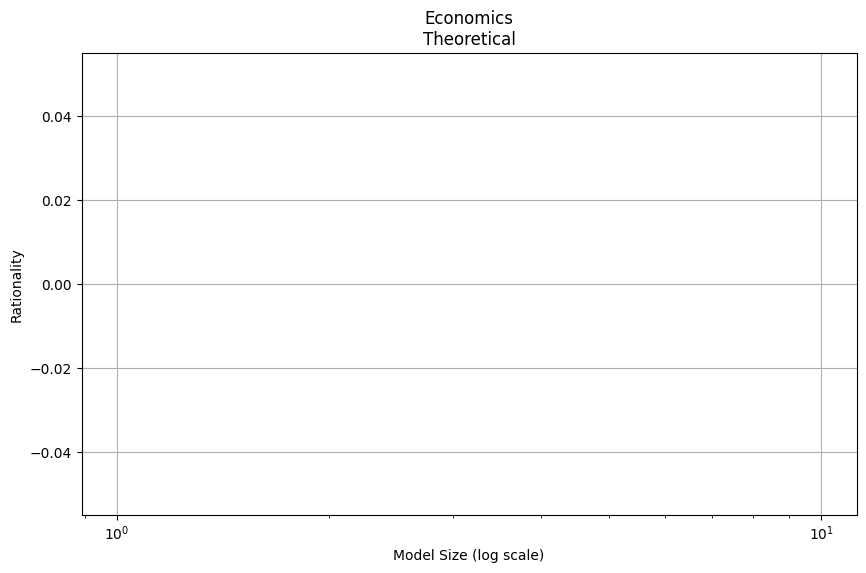

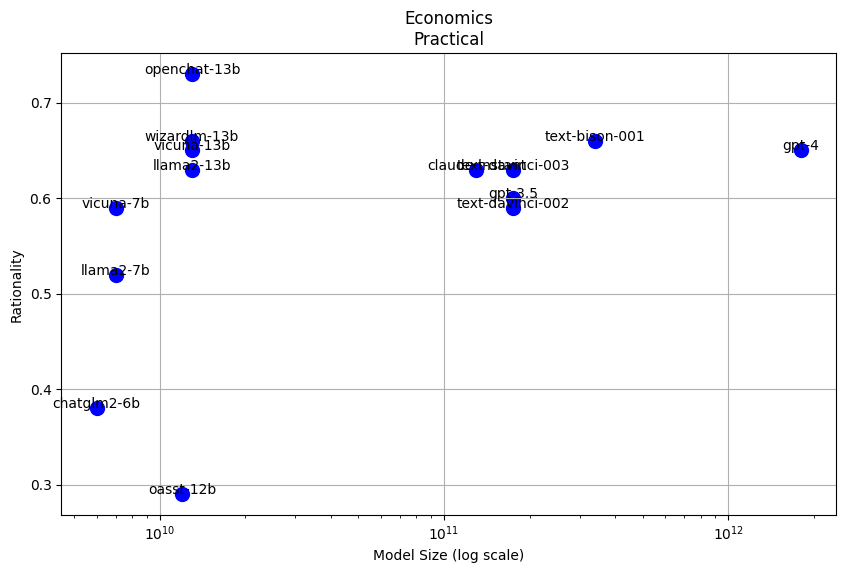

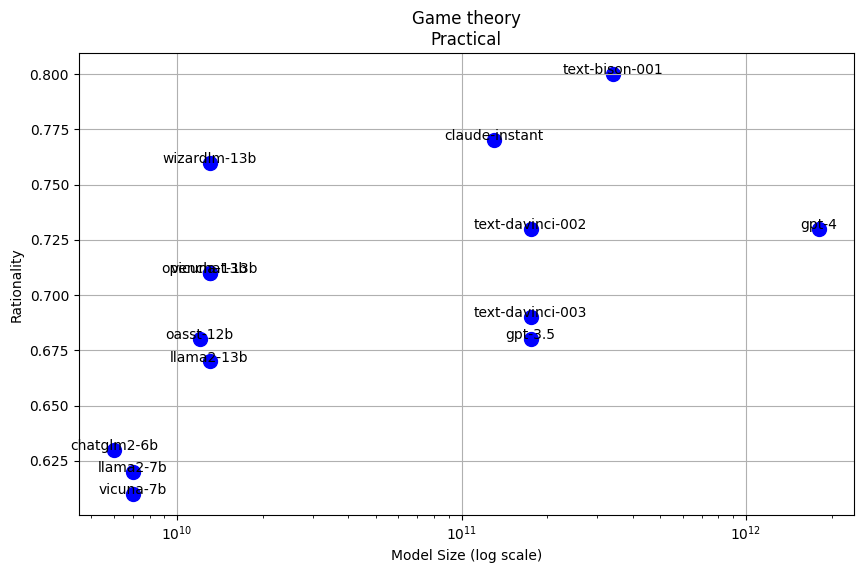

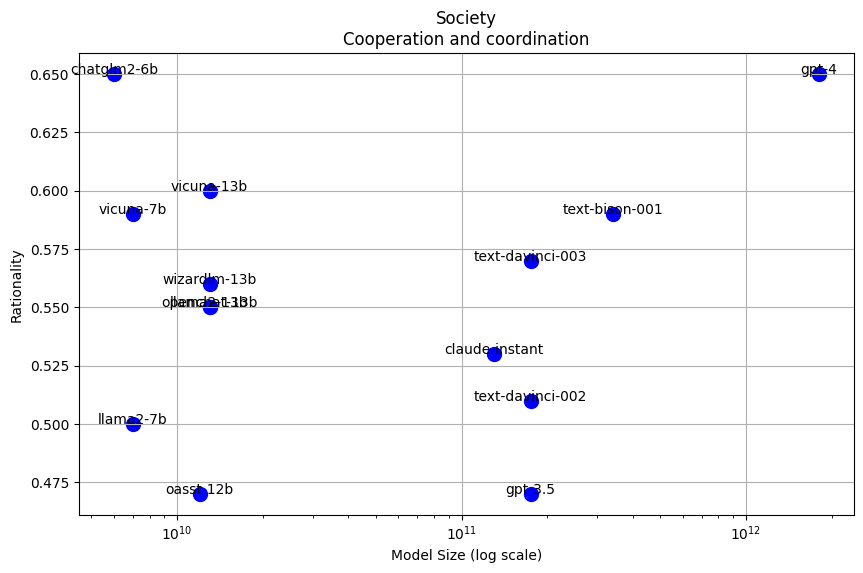

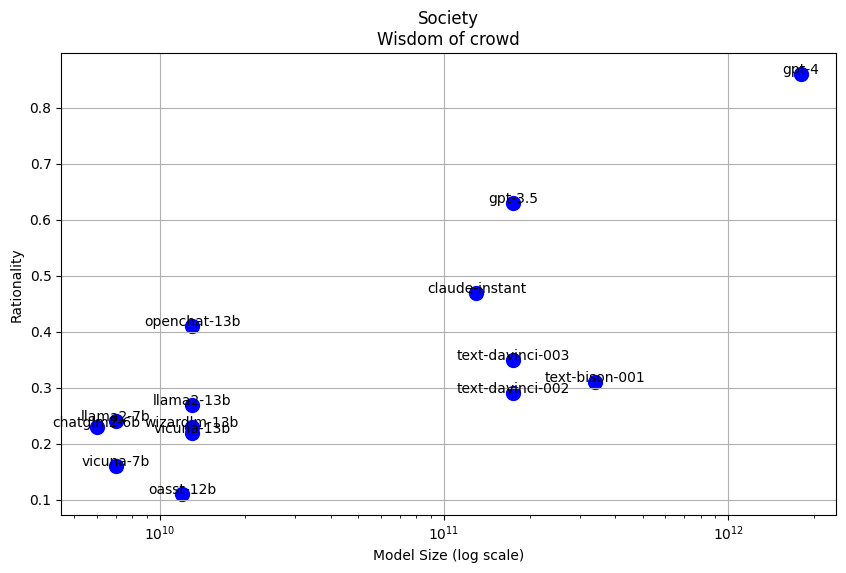

In [96]:
sizes=model_size.values*10**9

for domain in df1.index:
    average_row = df1.loc[domain,:]
    assert average_row.index.tolist()==model_size.index.tolist()
    models=average_row.index.tolist()
    rationalities=average_row.values
    
    # 创建散点图
    plt.figure(figsize=(10, 6))  # 设置图形大小
    plt.scatter(sizes, rationalities, marker='o', c='b', s=100)  # 创建散点图
#     plt.plot(sizes, rationalities, 'o-b')  # 创建折线图

    # 添加模型名称标签
    for i, model in enumerate(models):
#         if model=='text-davinci-002':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -5), ha='center')
#         elif model=='text-davinci-003':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
#         elif model=='wizardlm-13b':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 5), ha='center')
#         elif model=='vicuna-13b':
#             plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, -5), ha='center')
#         else:
        plt.annotate(model, (sizes[i], rationalities[i]), textcoords="offset points", xytext=(0, 0), ha='center')

    # 设置坐标轴
    plt.xscale('log')  # 设置横轴为对数坐标
    plt.xlabel('Model Size (log scale)')  # 设置横轴标签
    plt.ylabel('Rationality')  # 设置纵轴标签

    # 显示图形
    plt.grid(True)
    plt.title(f'{domain}')
    plt.show()

# RLHF

In [12]:
# 分domain
sel_cols=['Human','text-davinci-003','text-davinci-002']
df['name']=df['Domain']

df1=df[df['Type']=='Overall']

df1=df1[['name']+sel_cols]

df1=df1.set_index('name')

df1.columns=['Human','text-davinci-003\n(RLHF)','text-davinci-002']

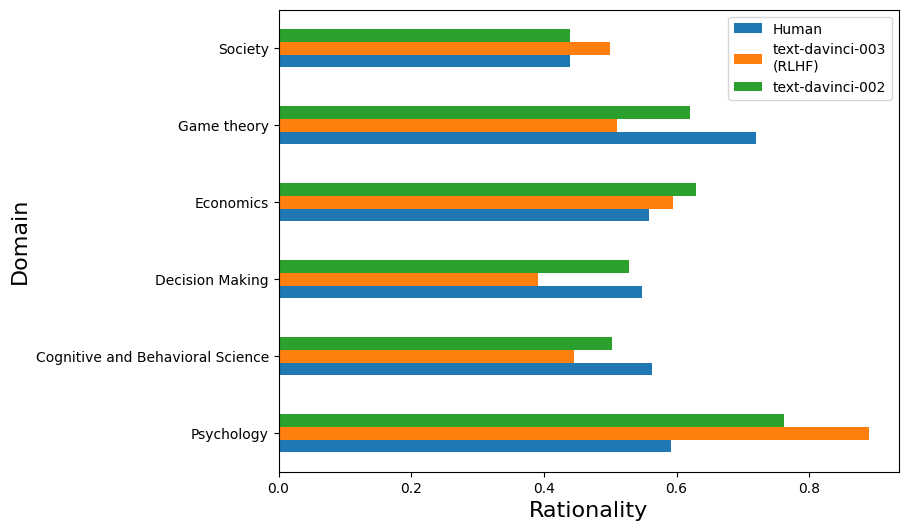

In [13]:

df1.plot.barh(figsize=(8,6))
plt.xlabel('Rationality',fontsize=16)
plt.ylabel('Domain',fontsize=16)
plt.savefig(os.path.join(plotpath, 'RLHF-1.pdf'), bbox_inches='tight')
plt.show()

In [14]:
# 分theory, practical
sel_cols=['Human','text-davinci-003','text-davinci-002']
df['name']=df['Domain']+'\n'+df['Type']

df1=df[df.apply(lambda x:x['Type'] in ['Theoretical','Practical'] ,axis=1)]

# df1=df1[['name']+sel_cols]

average_the=df1[df1['Type']=='Theoretical'][sel_cols].mean()

average_pra=df1[df1['Type']=='Practical'][sel_cols].mean()

In [15]:
df1=pd.DataFrame(columns=sel_cols)
df1 = pd.concat([df1, pd.DataFrame(average_the).T],axis=0)
df1 = pd.concat([df1, pd.DataFrame(average_pra).T],axis=0)
df1.index=['Theoretical','Practical']
df1.columns=['Human','text-davinci-003\n(RLHF)','text-davinci-002']
df1

,Human,text-davinci-003\n(RLHF),text-davinci-002
Theoretical,0.652000,0.655667,0.700667
Practical,0.583333,0.571000,0.598667


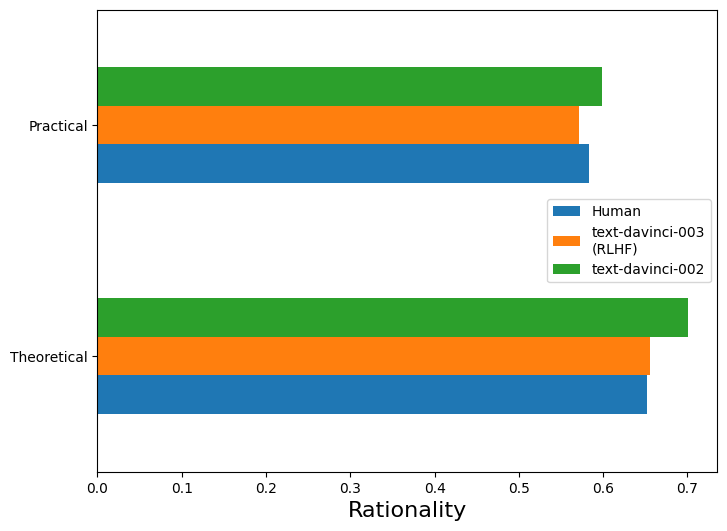

In [16]:
df1.plot.barh(figsize=(8,6))
plt.xlabel('Rationality',fontsize=16)
# plt.ylabel('Domain')
plt.savefig(os.path.join(plotpath, 'RLHF-2.pdf'), bbox_inches='tight')
plt.show()



# cross domain correlation

## 分theoretical和practical

In [28]:
df['name']=df['Domain']+'\n'+df['Type']

df1=df[df['Type']!='Overall']

df1=df1[['name']+col_order]
# df1=df1.set_index('name')
model_size=df1.iloc[0,:]
model_size=model_size.iloc[1:]

df1=df1.iloc[:-1,:]
df1=df1.iloc[1:,:].set_index('name')
df1=df1.dropna()
df1
# model_size

,gpt-4,text-bison-001,deepseek-v2.5,gpt-4o,gpt-3.5,text-davinci-003,text-davinci-002,claude-instant,qwen-72b,qwen-32b,openchat-13b,wizardlm-13b,vicuna-13b,llama2-13b,oasst-12b,qwen-7b,vicuna-7b,llama2-7b,chatglm2-6b
name,,,,,,,,,,,,,,,,,,,
Psychology\nTheoretical,0.800,0.520,0.758,0.750,0.758,0.850,0.780,0.730,0.925,0.830,0.704,0.758,0.754,0.813,0.645,0.742,0.770,0.588,0.533
Psychology\nPractical,0.634,0.764,0.769,0.690,0.639,0.917,0.750,0.588,0.787,0.763,0.805,0.792,0.611,0.625,0.667,0.773,0.736,0.690,0.681
Cognitive and Behavioral Science\nTheoretical,0.684,0.457,0.701,0.703,0.525,0.447,0.462,0.478,0.715,0.689,0.421,0.429,0.392,0.456,0.333,0.608,0.374,0.375,0.399
Cognitive and Behavioral Science\nPractical,0.717,0.521,0.598,0.660,0.474,0.507,0.640,0.740,0.757,0.714,0.557,0.660,0.724,0.695,0.543,0.814,0.579,0.471,0.576
Decision Making\nPractical,0.704,0.473,0.525,0.686,0.426,0.391,0.528,0.455,0.758,0.648,0.385,0.392,0.462,0.487,0.452,0.633,0.375,0.356,0.495
Economics\nTheoretical,0.920,0.960,0.960,0.960,0.900,0.670,0.860,0.930,0.930,0.930,0.920,0.920,0.830,0.830,0.570,0.960,0.570,0.790,0.670
Economics\nPractical,0.663,0.582,0.635,0.733,0.595,0.590,0.616,0.572,0.660,0.745,0.700,0.663,0.596,0.563,0.308,0.553,0.554,0.416,0.485
Game theory\nPractical,0.600,0.780,0.740,0.670,0.550,0.510,0.620,0.720,0.660,0.720,0.640,0.670,0.560,0.480,0.620,0.640,0.420,0.500,0.360
Society\nCooperation and coordination,0.650,0.590,0.380,0.620,0.470,0.570,0.510,0.530,0.680,0.400,0.550,0.560,0.600,0.550,0.470,0.520,0.590,0.500,0.650


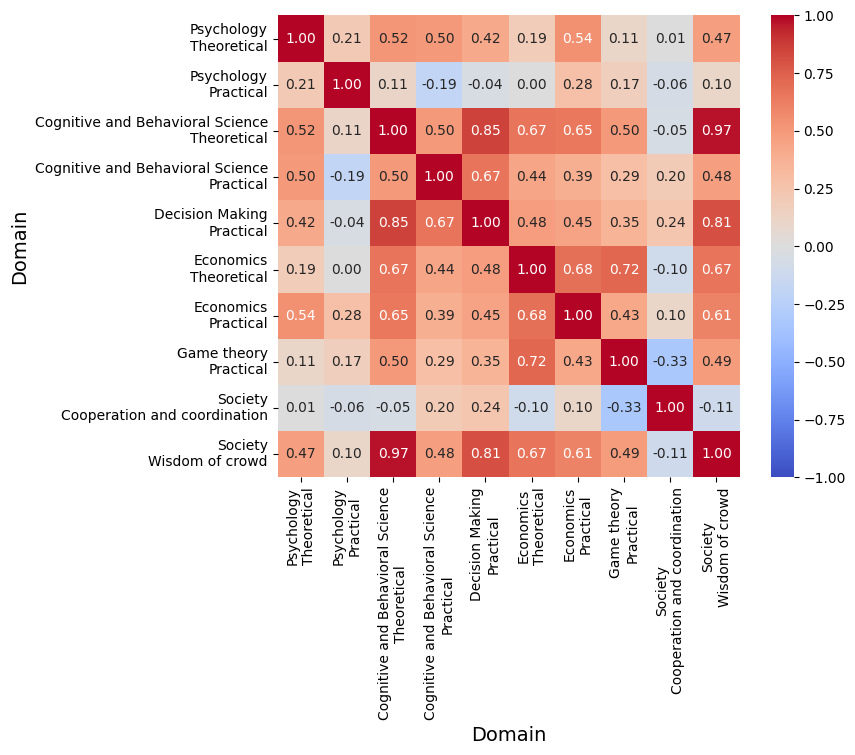

In [29]:
correlation_matrix = df1.T.corr()

# 使用Seaborn绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f", vmin=-1, vmax=1)

# plt.title('Cross-domain Correlation')
plt.xlabel('Domain', fontsize=14)
plt.ylabel('Domain', fontsize=14)
plt.savefig(os.path.join(plotpath, 'correlation-1.pdf'), bbox_inches='tight')
plt.show()

## Overall

In [30]:
# df['name']=df['Domain']+'\n'+df['Type']
df['name']=df['Domain']

df1=df[df['Type']=='Overall']

df1=df1[['name']+col_order]
# df1=df1.set_index('name')
model_size=df1.iloc[0,:]
model_size=model_size.iloc[1:]

df1=df1.set_index('name')
df1=df1.dropna()
df1
# model_size

,gpt-4,text-bison-001,deepseek-v2.5,gpt-4o,gpt-3.5,text-davinci-003,text-davinci-002,claude-instant,qwen-72b,qwen-32b,openchat-13b,wizardlm-13b,vicuna-13b,llama2-13b,oasst-12b,qwen-7b,vicuna-7b,llama2-7b,chatglm2-6b
name,,,,,,,,,,,,,,,,,,,
Psychology,0.700,0.666,0.764,0.714,0.686,0.890,0.762,0.645,0.842,0.790,0.765,0.778,0.668,0.700,0.658,0.761,0.750,0.649,0.622
Cognitive and Behavioral Science,0.688,0.461,0.668,0.685,0.501,0.445,0.503,0.547,0.726,0.694,0.446,0.486,0.483,0.513,0.392,0.664,0.419,0.382,0.458
Decision Making,0.704,0.473,0.525,0.686,0.426,0.391,0.528,0.455,0.758,0.648,0.385,0.392,0.462,0.487,0.452,0.633,0.375,0.356,0.495
Economics,0.677,0.602,0.652,0.745,0.612,0.594,0.629,0.591,0.674,0.755,0.711,0.676,0.609,0.577,0.322,0.574,0.555,0.436,0.495
Game theory,0.600,0.780,0.740,0.670,0.550,0.510,0.620,0.720,0.660,0.720,0.640,0.670,0.560,0.480,0.620,0.640,0.420,0.500,0.360
Society,0.720,0.500,0.530,0.700,0.520,0.500,0.440,0.510,0.750,0.570,0.500,0.450,0.470,0.460,0.350,0.640,0.450,0.410,0.510


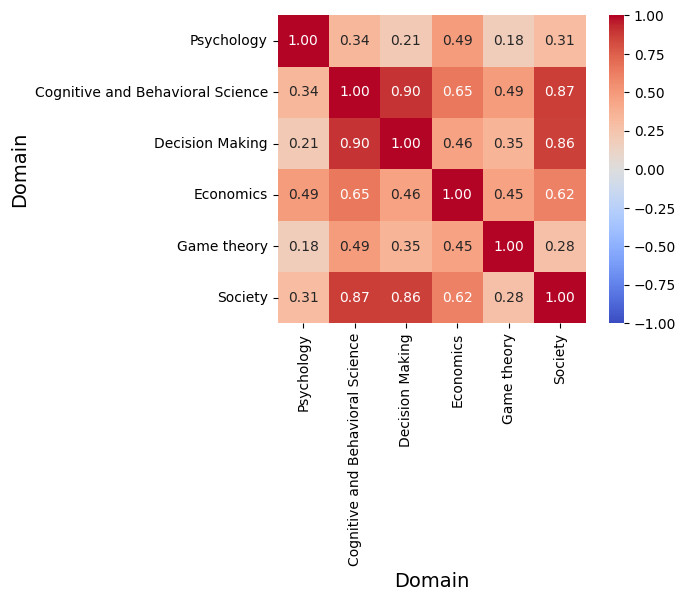

In [31]:
correlation_matrix = df1.T.corr()

# 使用Seaborn绘制热力图
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f", vmin=-1, vmax=1)

# plt.title('Cross-domain Correlation')
plt.xlabel('Domain', fontsize=14)
plt.ylabel('Domain', fontsize=14)
plt.savefig(os.path.join(plotpath, 'correlation-2.pdf'), bbox_inches='tight')
# plt.show()

# Theoretical vs practical

In [ ]:
散点图，横轴theoretical,纵轴practical，每个模型一个点

In [32]:
df1=df[df['Type']=='Theoretical']
df1=df1[col_order]
average_the=df1.mean()

df1=df[df['Type']=='Practical']
df1=df1[col_order]
average_pra=df1.mean()

In [33]:
assert average_the.index.tolist()==average_pra.index.tolist()
models=average_the.index.tolist()
the=average_the.values
pra=average_pra.values

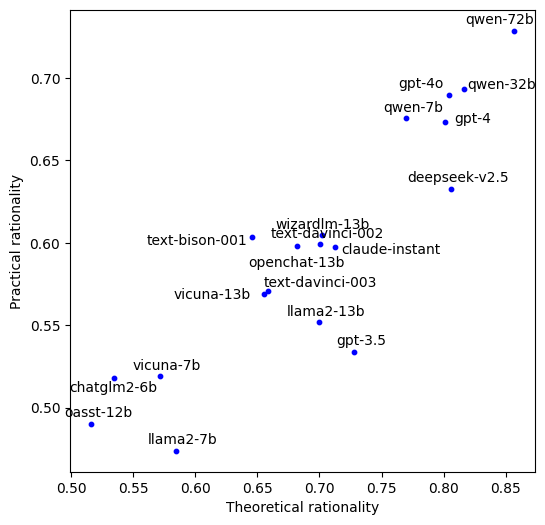

In [46]:
# 创建散点图

pltx=the.astype(float)
plty=pra

plt.figure(figsize=(6, 6))  # 设置图形大小
plt.scatter(pltx, plty, marker='o', c='b', s=10)  # 创建散点图
# plt.plot(pltx, plty, 'o-b')  # 创建散点图

# 添加模型名称标签
for i, model in enumerate(models):
    if model=='text-bison-001':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(-40, -5), ha='center')
    elif model=='text-davinci-003':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(40, 5), ha='center')
    elif model=='wizardlm-13b':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    elif model=='vicuna-13b':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(-40, -5), ha='center')
    elif model=='openchat-13b':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(0, -15), ha='center')
    elif model=='claude-instant':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(40, -5), ha='center')
    elif model=='chatglm2-6b':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(0, -10), ha='center')
    elif model=='qwen-72b':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(-10, 5), ha='center')
    elif model=='qwen-32b':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(27, 0), ha='center')
    elif model=='gpt-4o':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(-20, 5), ha='center')
    elif model=='gpt-4':
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(20, 0), ha='center')
    else:
        plt.annotate(model, (pltx[i], plty[i]), textcoords="offset points", xytext=(5, 5), ha='center')

# 设置坐标轴
plt.xlabel('Theoretical rationality')  # 设置横轴标签
plt.ylabel('Practical rationality')  # 设置纵轴标签

# 显示图形
# plt.grid(True)
# plt.title('All domains')
plt.savefig(os.path.join(plotpath, 'theo-prac.pdf'), bbox_inches='tight')
plt.show()

In [41]:
plty

array([0.66166667, 0.60666667, 0.56833333, 0.61166667, 0.63      ,
       0.61666667, 0.60166667, 0.58      , 0.58833333, 0.585     ,
       0.515     , 0.555     , 0.51833333, 0.54      ])